## Markov Model of a Three-Tank Duel - Part 2

In [8]:
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict

# Define hit probabilities
hit_probs = {
    'A': 1/3,
    'B': 1/4,
    'C': 1/5
}

# Define all possible states
states = ['ABC', 'AB', 'AC', 'BC', 'A', 'B', 'C', '∅']
absorbing_states = ['A', 'B', 'C', '∅']

# Determine strongest opponent function
def strongest_opponent(tank, others):
    if not others:
        return None
    return max(others, key=lambda x: hit_probs[x])

# Function to get next state probabilities from current state
def transition_from_state(state):
    tanks = list(state)
    transitions = defaultdict(float)

    if state in absorbing_states:
        transitions[state] = 1.0
        return transitions

    # Each tank selects its strongest opponent
    targets = {}
    for t in tanks:
        others = [o for o in tanks if o != t]
        targets[t] = strongest_opponent(t, others)

    # Generate all combinations of hits/misses
    for outcome in product([True, False], repeat=len(tanks)):
        prob = 1.0
        eliminated = set()

        for i, t in enumerate(tanks):
            target = targets[t]
            if target:
                if outcome[i]:  # hit
                    prob *= hit_probs[t]
                    eliminated.add(target)
                else:
                    prob *= (1 - hit_probs[t])
        
        survivors = [t for t in tanks if t not in eliminated]
        new_state = ''.join(sorted(survivors)) if survivors else '∅'
        transitions[new_state] += prob

    return transitions

# Build the transition matrix
transition_matrix = pd.DataFrame(0.0, index=states, columns=states)

for state in states:
    transitions = transition_from_state(state)
    for target_state, prob in transitions.items():
        transition_matrix.loc[state, target_state] = prob

# Separate transient and absorbing states
transient_states = [s for s in states if s not in absorbing_states]
Q = transition_matrix.loc[transient_states, transient_states]
R = transition_matrix.loc[transient_states, absorbing_states]

# Fundamental matrix: N = (I - Q)^(-1)
I = np.eye(len(Q))
N = np.linalg.inv(I - Q.values)
N_df = pd.DataFrame(N, index=Q.index, columns=Q.columns)

# Expected number of steps from each transient state
expected_steps = N.sum(axis=1)
expected_steps_df = pd.DataFrame(expected_steps, index=Q.index, columns=["Expected Steps"])

# Absorption probabilities: B = N * R
B = N @ R.values
B_df = pd.DataFrame(B, index=Q.index, columns=R.columns)

# Print everything to console
print("\n===== Transition Matrix =====")
print(transition_matrix.round(4))

print("\n===== Fundamental Matrix (N) =====")
print(N_df.round(4))

print("\n===== Expected Steps to Absorption =====")
print(expected_steps_df.round(4))

print("\n===== Absorption Probabilities =====")
print(B_df.round(4))


===== Transition Matrix =====
     ABC   AB      AC      BC       A       B       C       ∅
ABC  0.4  0.0  0.2000  0.2667  0.0000  0.0000  0.1333  0.0000
AB   0.0  0.5  0.0000  0.0000  0.2500  0.1667  0.0000  0.0833
AC   0.0  0.0  0.5333  0.0000  0.2667  0.0000  0.1333  0.0667
BC   0.0  0.0  0.0000  0.6000  0.0000  0.2000  0.1500  0.0500
A    0.0  0.0  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000
B    0.0  0.0  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000
C    0.0  0.0  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000
∅    0.0  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000

===== Fundamental Matrix (N) =====
        ABC   AB      AC      BC
ABC  1.6667  0.0  0.7143  1.1111
AB   0.0000  2.0  0.0000  0.0000
AC   0.0000  0.0  2.1429  0.0000
BC   0.0000  0.0  0.0000  2.5000

===== Expected Steps to Absorption =====
     Expected Steps
ABC          3.4921
AB           2.0000
AC           2.1429
BC           2.5000

===== Absorption Probabilities =====
          A       B       C   

## Graph Visualization

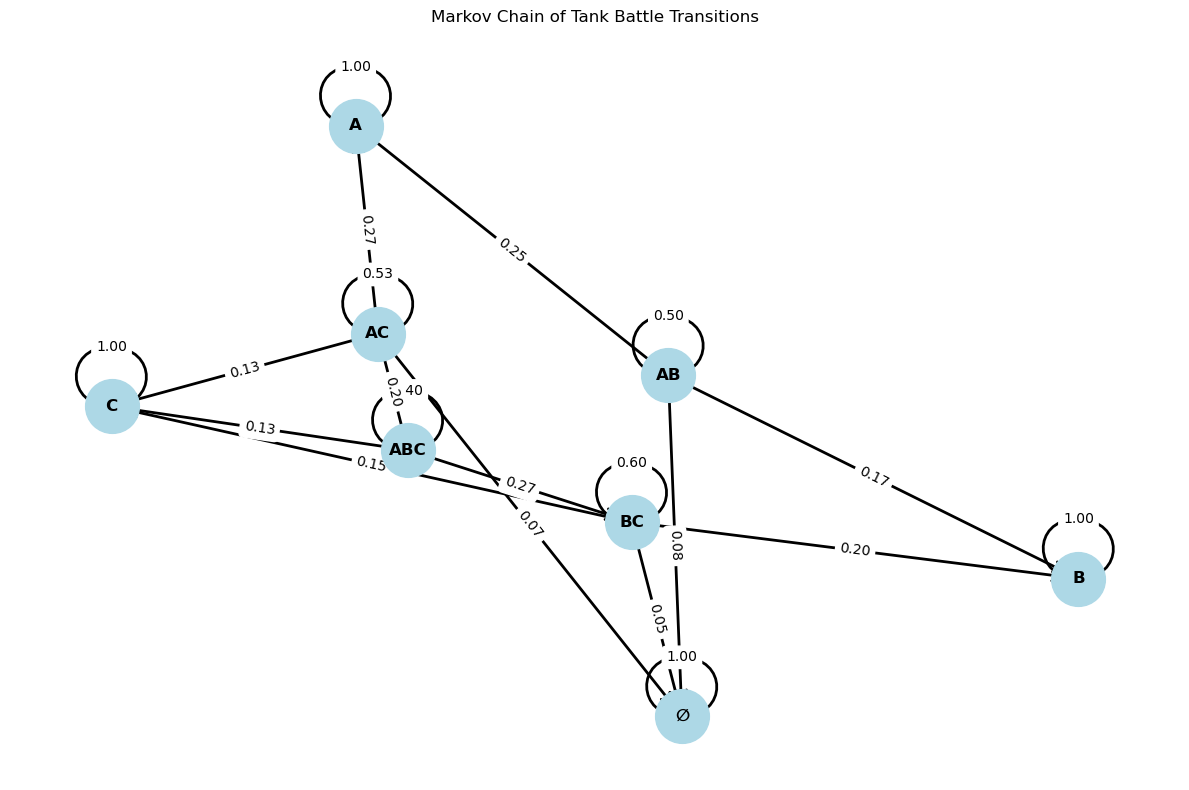

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add edges with probabilities from the transition matrix
for from_state in transition_matrix.index:
    for to_state in transition_matrix.columns:
        prob = transition_matrix.loc[from_state, to_state]
        if prob > 0.01:  # filter out tiny probabilities for clarity
            G.add_edge(from_state, to_state, weight=prob)

# Layout and draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edge labels with transition probabilities
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Markov Chain of Tank Battle Transitions")
plt.axis('off')
plt.tight_layout()
plt.show()